d:\projects\gly4930-antartic-bed-mapping\.venv\lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (d:\projects\gly4930-antartic-bed-mapping\.venv\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


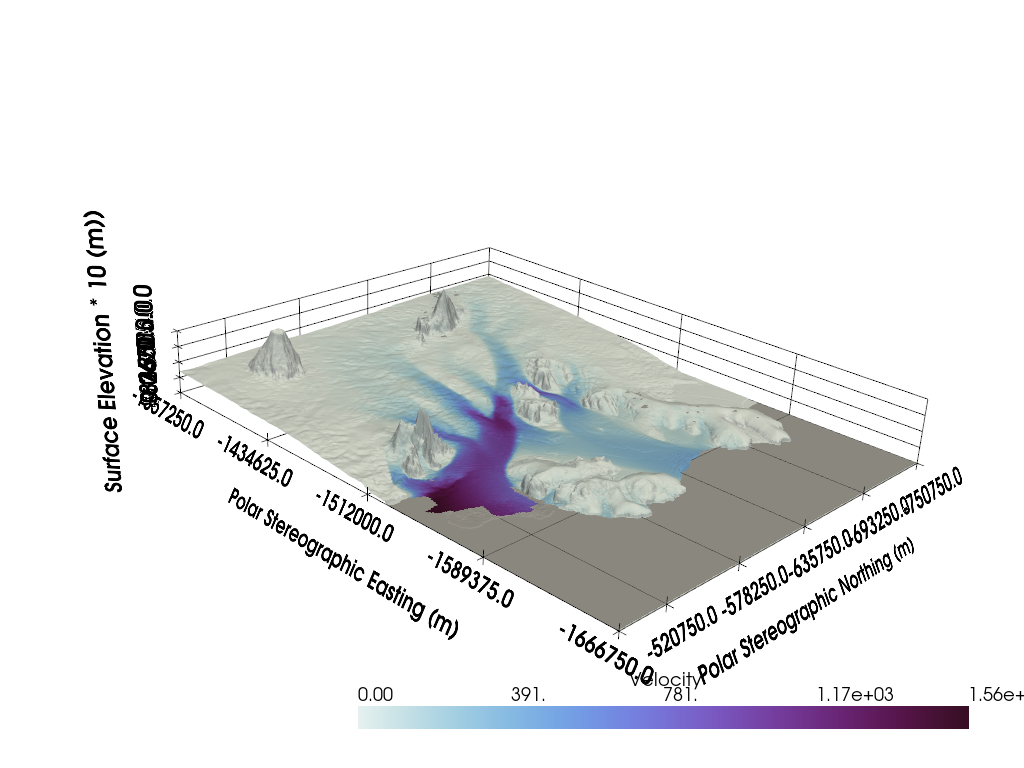

In [2]:
#NOTE reason why we can't use interactive version of pyvista in notebook
# https://github.com/pyvista/pyvista/issues/5848
# probably you did not installed pyvista with the jupyter option (pip install "pyvista[jupyter]")

import numpy as np
import pandas as pd
import pyvista as pv
import cmocean

# Code to load data and get into grid from Lab 1
df = pd.read_csv('../data/KohlerPopeSmith.csv')

# Compute ice velocity magnitude
vel_mag = np.sqrt(df['velx']**2 + df['vely']**2)

# Create structured grid
x_unique = np.unique(df['x'])
y_unique = np.unique(df['y'])
xx, yy = np.meshgrid(x_unique, y_unique)
shape = xx.shape

# Add 3rd dimension
zz = np.nan_to_num(df['surf'].values.reshape(shape), nan=0.0)
vel_grid = vel_mag.values.reshape(shape)

# Cast to float32 for PyVista 
xx = xx.astype(np.float32)
yy = yy.astype(np.float32)
zz = zz.astype(np.float32)

# Vertical exaggeration to accentuate Z-axis features
z_exaggeration = 10
zz_exag = zz * z_exaggeration

# Extend grid in x direction to make room for ASE text (applied in Photoshop)
extra_x = np.full((xx.shape[0], 1), xx.min() - 40000, dtype=np.float32)
xx_ext = np.hstack([extra_x, xx])
yy_ext = np.hstack([yy[:, 0:1], yy])  # repeat first column
zz_ext = np.hstack([np.zeros((zz_exag.shape[0], 1), dtype=np.float32), zz_exag])
vel_ext = np.hstack([np.zeros((vel_grid.shape[0], 1), dtype=np.float32), vel_grid])

# Create the extended grid
grid_ext = pv.StructuredGrid(xx_ext, yy_ext, zz_ext)
grid_ext['Velocity'] = vel_ext.ravel(order='F')

# Plot
p = pv.Plotter()
p.add_mesh(grid_ext, scalars='Velocity', cmap=cmocean.cm.dense, show_edges=False)

# Use show_grid to set axis labels
p.show_grid(
    xtitle='Polar Stereographic Easting (m)',
    ytitle='Polar Stereographic Northing (m)',
    ztitle=f'Surface Elevation * {z_exaggeration} (m))'
)

# Use saved data to orient the camera
saved_camera = [
    (-1968892.882139573, -237129.68811485582 + 100000, 312324.56602184003),  # camera location
    (-1492000.0, -635750.0, 17670.0),                                         # focal point
    (0.325983774305665, -0.2779328938107925, 0.9035971920205331)              # view up
]
p.camera_position = saved_camera

p.show()

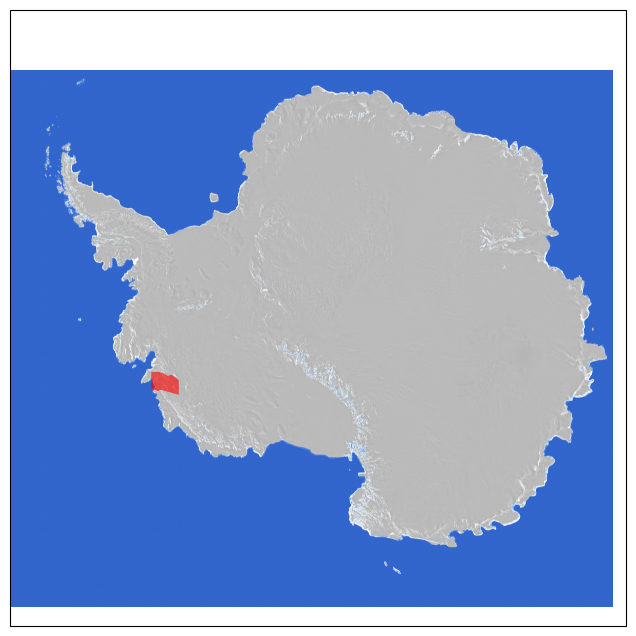

In [ ]:
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import box
import geopandas as gpd
import numpy as np
import matplotlib.colors as mcolors
from shapely.geometry import Polygon

# MOA High Pass 1 raster location
moa_path = "../data/moa125_2014_hp1_v01.tif"

# Study area
xmin, xmax = -1626750, -1356750
ymin, ymax = -750750, -520250

# Open MOA raster
with rasterio.open(moa_path) as src:
    moa_crs = src.crs or rasterio.crs.CRS.from_epsg(3031)  # assume EPSG:3031 if missing

    # Downsample for speed
    scale = 0.25
    out_height = int(src.height * scale)
    out_width = int(src.width * scale)

    moa = src.read(1, out_shape=(out_height, out_width), resampling=Resampling.bilinear)

    transform = src.transform * src.transform.scale(src.width / out_width, src.height / out_height)

    # compute extent
    left, bottom = transform * (0, out_height)
    right, top = transform * (out_width, 0)
    extent = [left, right, bottom, top]

# Clip and normalize data
# Ignore NaNs or extreme outliers for visualization
moa = np.where(np.isfinite(moa), moa, np.nan)
vmin, vmax = np.nanpercentile(moa, [2, 98])
moa_clipped = np.clip(moa, vmin, vmax)

# Custom colormap
colors = [
    (0.2, 0.4, 0.8),  # deep blue
    (0.7, 0.85, 1.0), # light blue
    (1.0, 1.0, 1.0),  # pure white (ice)
    (0.7, 0.7, 0.7),  # light gray (mountains)
]
nodes = [0.0, 0.4, 0.8, 1.0]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("antarctica", list(zip(nodes, colors)))

# Create GeoDataFrame for study area box
study_box = gpd.GeoDataFrame(geometry=[box(xmin, ymin, xmax, ymax)], crs=moa_crs)

# Kohler, Pope, Smith study area polygon
poly_kps = [(-1624250, -525250), (-1544250, -525250), (-1530250, -533750), (-1515250, -533750), 
            (-1475250, -557750), (-1468102, -563551), (-1425250, -552750), (-1356039, -603747), 
            (-1356039, -747750), (-1525250, -700750), (-1560839, -710812), (-1624250, -690812) ]

# Create GeoDataFrame for study area polygon
poly_geom = Polygon(poly_kps)
study_area_poly = gpd.GeoDataFrame(
    geometry=[poly_geom],
    crs=moa_crs
)

# Plot with Cartopy 
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

# Plot MOA raster
ax.imshow(moa_clipped, origin='upper', extent=extent,
    transform=ccrs.SouthPolarStereo(), cmap=custom_cmap)

# Overlay shaded study area
study_area_poly.plot(ax=ax, transform=ccrs.SouthPolarStereo(), 
                     facecolor='red', edgecolor='none', alpha=0.6)


# Set extent
ax.set_extent([-3e6, 3e6, -3e6, 3e6], crs=ccrs.SouthPolarStereo())

plt.show()

NOTICE! The region mask in bedmap will automatically be interpolated using nearest neighbor interpolation method
NOTICE! The categorical data in bedmachine will automatically be interpolated using nearest neighbor interpolation method


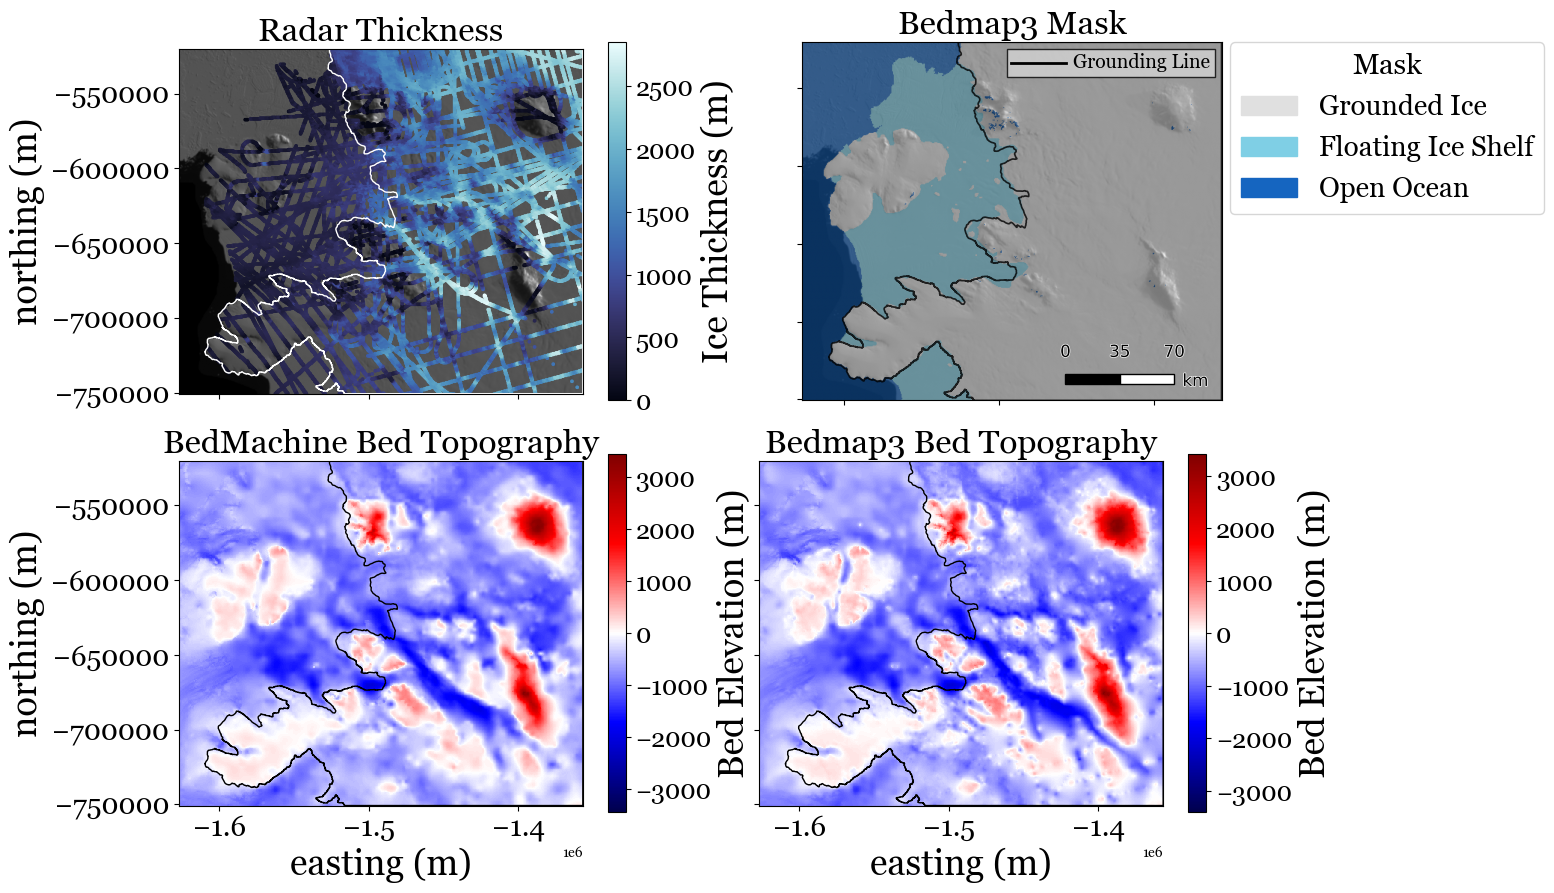

In [2]:
import geopandas as gpd
import numpy as np

import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib_map_utils.core.scale_bar import scale_bar
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredOffsetbox, HPacker, TextArea, DrawingArea
import matplotlib.cm as cm
import cmocean

import Topography

# Change font to Georgia
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Georgia']

# Font sizes 
label_fontsize = 26
tick_fontsize = 14
title_fontsize = 24
colorbar_labelsize = 26
colorbar_ticksize = 18

# KPS study area
xmin, xmax = -1626750, -1356750
ymin, ymax = -750750, -520250
resolution = 500

# bounds for radar data
xmin_ant, xmax_ant = -3333250, 3333250
ymin_ant, ymax_ant = -3333250, 3333250
xx_ant, yy_ant = np.meshgrid(np.arange(xmin_ant, xmax_ant + resolution, resolution),
                             np.arange(ymin_ant, ymax_ant + resolution, resolution))
xmin_ind = np.where(xx_ant == xmin)[1][0]
xmax_ind = np.where(xx_ant == xmax)[1][0]
ymin_ind = np.where(yy_ant == ymin)[0][0]
ymax_ind = np.where(yy_ant == ymax)[0][0]

# Load radar thickness
radar_thickness = np.load('../data/bedmap3_raw_thick_compilation.npy')
radar_thickness = np.flip(radar_thickness, axis=0)
radar_thickness = radar_thickness[ymin_ind:ymax_ind, xmin_ind:xmax_ind]
xx, yy = np.meshgrid(np.arange(xmin, xmax, resolution),
                     np.arange(ymin, ymax, resolution))

# Load MOA 125m High Pass 1 image
# https://daacdata.apps.nsidc.org/pub/DATASETS/ 
with rasterio.open('../data/moa125_2014_hp1_v01.tif') as src:
    row_start, col_start = src.index(xmin, ymax)
    row_stop, col_stop = src.index(xmax, ymin)
    row_start, row_stop = min(row_start, row_stop), max(row_start, row_stop)
    col_start, col_stop = min(col_start, col_stop), max(col_start, col_stop)
    window = rasterio.windows.Window.from_slices((row_start, row_stop), (col_start, col_stop))
    moa_data = src.read(1, window=window, out_shape=(xx.shape[0], xx.shape[1]),
                        resampling=Resampling.bilinear)
moa_data = np.flipud(moa_data)

# Load grounding line
gl = gpd.read_file('./../data/moa2014_groundingline_v01/moa2014_grounding_line_v01.shp')
glau = gl.geometry.clip_by_rect(xmin, ymin, xmax, ymax)
glaux, glauy = glau[0].exterior.xy

# Load Bedmap3 mask and topography
bedmap_mask, bedmap_surf, bedmap_bed, bedmap_bed_uncertainty, _ = Topography.load_bedmap('../data/bedmap3.nc', xx, yy, resolution)

# Load BedMachine topography
bm_mask, bm_source, bm_bed, bm_surface, bm_errbed, _ = Topography.load_bedmachine('../data/BedMachineAntarctica-v3.nc', xx, yy, resolution)

# Create 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10), gridspec_kw={'hspace':0.15, 'wspace':0.15})

# (a) Radar Measurements
ax = axes[0,0]
ax.imshow(moa_data, extent=(xmin,xmax,ymin,ymax), origin='lower', cmap='gray', alpha=1.0)
scatter = ax.scatter(xx.flatten(), yy.flatten(), c=radar_thickness.flatten(), cmap=cmocean.cm.ice, s=1)
ax.plot(glaux, glauy, color='white', linewidth=1.0)
ax.set_title('Radar Thickness', fontsize=title_fontsize)
ax.set_ylabel('northing (m)', fontsize=label_fontsize)
ax.set_aspect('equal')
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Ice Thickness (m)', fontsize=colorbar_labelsize)
cbar.ax.tick_params(labelsize=colorbar_ticksize)

# (b) Bedmap Mask
# Define Bedmap mask colormap
cmap_mask = ListedColormap([
    '#e0e0e0',  # Grounded Ice
    '#7fcfe5',  # Floating Ice Shelf
    '#1565c0'   # Open Ocean
])
norm_mask = BoundaryNorm([0.5, 2.0, 3.5, 4.5], cmap_mask.N)
mask_labels = ['Grounded Ice', 'Floating Ice Shelf', 'Open Ocean']

ax = axes[0,1]
ax.imshow(moa_data, extent=(xmin,xmax,ymin,ymax), origin='lower', cmap='gray', alpha=1.0)
ax.imshow(cmap_mask(norm_mask(bedmap_mask)), extent=(xmin,xmax,ymin,ymax), origin='lower', alpha=0.5)
ax.plot(glaux, glauy, color='black', linewidth=1.2, alpha=0.8)
ax.set_title('Bedmap3 Mask', fontsize=title_fontsize)
ax.set_xlabel('easting (m)', fontsize=label_fontsize)
ax.set_ylabel('northing (m)', fontsize=label_fontsize)
ax.set_aspect('equal')

# Legend for mask
patches = [mpatches.Patch(color=cmap_mask(i), label=mask_labels[i]) for i in range(3)]
ax.legend(handles=patches, title='Mask', loc='upper left',
          bbox_to_anchor=(1.02,1), borderaxespad=0,
          frameon=True, fontsize=label_fontsize-6, title_fontsize=label_fontsize-5)

# Grounding line label
line_width = 40
da = DrawingArea(line_width, 10, 0, 0)
da.add_artist(Line2D([0,line_width],[5,5], color='black', lw=2))
txt = TextArea("Grounding Line", textprops={'fontsize':16-2})
box = HPacker(children=[da, txt], align="center", pad=0, sep=5)
anchored_box = AnchoredOffsetbox(loc='upper right', child=box, pad=0.3, frameon=True,
                                 bbox_transform=ax.transAxes)
anchored_box.patch.set_facecolor('lightgray')
anchored_box.patch.set_alpha(0.8)
ax.add_artist(anchored_box)

# Scale bar
scale_bar(ax, location="lower right", style="boxes", bar={"projection": "EPSG:3031"})

# (c) BedMachine
ax = axes[1,0]
max_abs = np.nanmax(np.abs(bm_bed))
im = ax.pcolormesh(xx, yy, bm_bed, cmap=cm.seismic, vmin=-max_abs, vmax=max_abs, shading='auto')
ax.plot(glaux, glauy, color='black', linewidth=1.0)
ax.set_title('BedMachine Bed Topography', fontsize=title_fontsize)
ax.set_xlabel('easting (m)', fontsize=label_fontsize)
ax.set_ylabel('northing (m)', fontsize=label_fontsize)
ax.set_aspect('equal')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Bed Elevation (m)', fontsize=colorbar_labelsize)
cbar.ax.tick_params(labelsize=colorbar_ticksize)

# (d) Bedmap3
ax = axes[1,1]
max_abs = np.nanmax(np.abs(bedmap_bed))
im = ax.pcolormesh(xx, yy, bedmap_bed, cmap=cm.seismic, vmin=-max_abs, vmax=max_abs, shading='auto')
ax.plot(glaux, glauy, color='black', linewidth=1.0)
ax.set_title('Bedmap3 Bed Topography', fontsize=title_fontsize)
ax.set_xlabel('easting (m)', fontsize=label_fontsize)
ax.set_aspect('equal')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Bed Elevation (m)', fontsize=colorbar_labelsize)
cbar.ax.tick_params(labelsize=colorbar_ticksize)

# Adjust axes
axes[0,0].set_xticklabels([])
axes[1,1].set_yticklabels([])

for ax in axes.flat:
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.label_outer()
    ax.tick_params(labelsize=20)

plt.show()


NOTICE! The region mask in bedmap will automatically be interpolated using nearest neighbor interpolation method


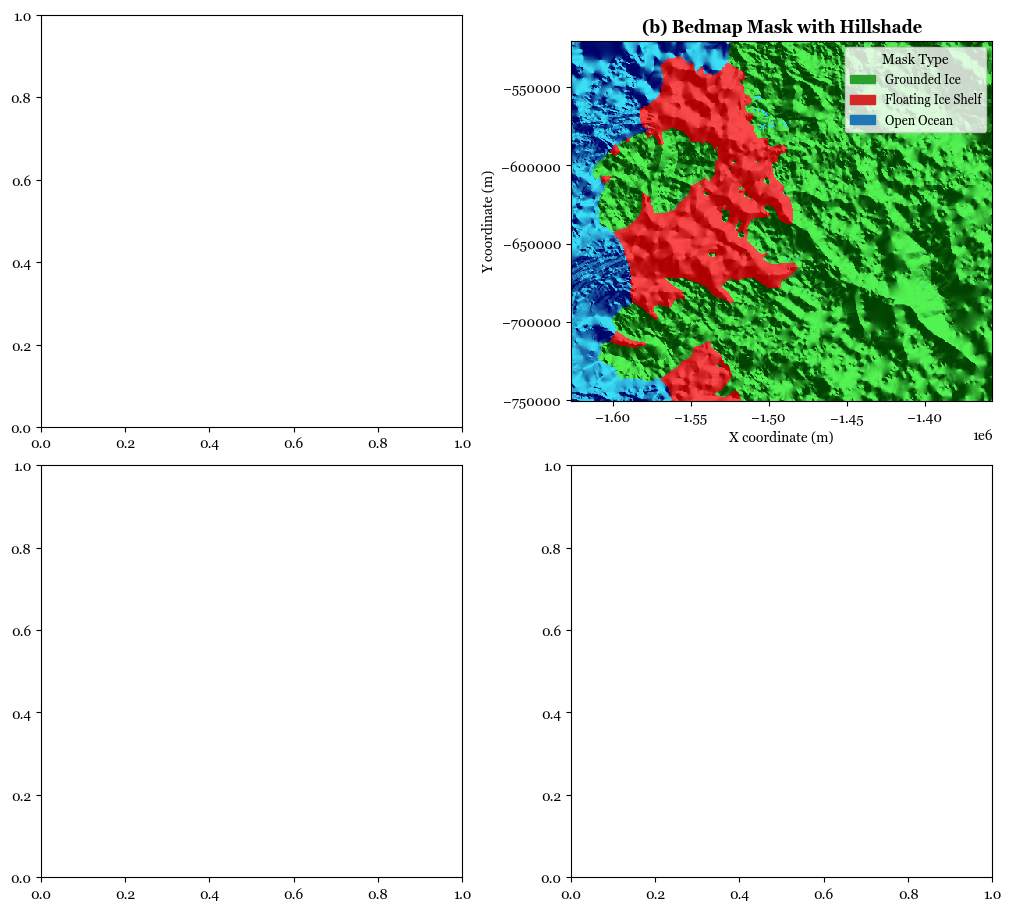

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import Topography
from matplotlib.colors import LightSource, ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Georgia']

xmin = -1626750
xmax = -1356750
ymin = -750750
ymax = -520250
resolution = 500

xx = np.arange(xmin, xmax + resolution, resolution)
yy = np.arange(ymin, ymax + resolution, resolution)
xx, yy = np.meshgrid(xx, yy)

fig, axes = plt.subplots(2, 2, figsize=(10, 9), constrained_layout=True)

bedmap_mask, bedmap_surf, bedmap_bed, bedmap_bed_uncertainty, _ = Topography.load_bedmap(
    '../data/bedmap3.nc', xx, yy, resolution
)

# Create hillshade from bed topography
ls = LightSource(azdeg=315, altdeg=45)
# Apply vertical exaggeration of 10
rgb_hillshade = ls.shade(
    bedmap_surf,
    cmap=ListedColormap(['white']),  # base color (we only want shading)
    vert_exag=1,
    blend_mode='overlay'
)

# Define discrete categories and colormap for mask
categories = [1.0, 3.0, 4.0]
labels = ['Grounded Ice', 'Floating Ice Shelf', 'Open Ocean']
colors = ['#2ca02c', '#d62728', '#1f77b4']  # blue, green, red
cmap = ListedColormap(colors)
norm = BoundaryNorm([0.5, 2.0, 3.5, 4.5], cmap.N)  # bins centered on 1,3,4

# Overlay mask colors on hillshade
rgb_mask = ls.shade_rgb(cmap(norm(bedmap_mask)), elevation=bedmap_bed, vert_exag=10, blend_mode='overlay')

# Plot on axes
axes[0, 1].imshow(
    rgb_mask,
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    origin='lower',
    interpolation='nearest'
)
axes[0, 1].set_title('(b) Bedmap Mask with Hillshade', fontsize=12, fontweight='bold', fontfamily='Georgia')
axes[0, 1].set_xlabel('X coordinate (m)', fontsize=10, fontfamily='Georgia')
axes[0, 1].set_ylabel('Y coordinate (m)', fontsize=10, fontfamily='Georgia')
axes[0, 1].set_aspect('equal')

# Add categorical legend
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(categories))]
axes[0, 1].legend(handles=patches, title='Mask Type', title_fontsize=10, fontsize=9, loc='upper right', frameon=True)

plt.show()


(-1621.920937509253, -1344.1228124995594, -762.275, -508.725)

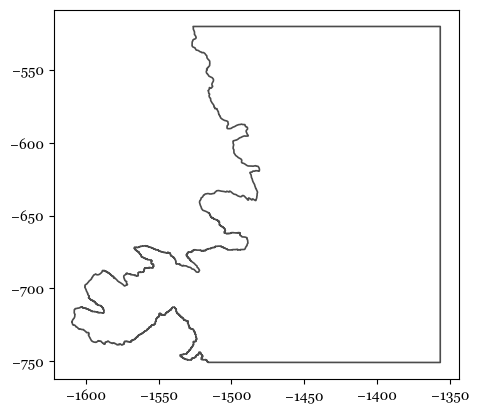

In [ ]:
# Niya's code for loading a grounding line from MOA grounding line shapefile
xmin = -1626750
xmax = -1356750
ymin = -750750
ymax = -520250

# Load grounding line from a file
gl = gpd.read_file('./../data/moa2014_groundingline_v01/moa2014_grounding_line_v01.shp')
glx,gly = gl.geometry[0].exterior.xy
glau = gl.geometry.clip_by_rect(xmin, ymin, xmax, ymax)
glaux,glauy = glau[0].exterior.xy

# Plot the grounding line
# Feel free to change the parameters for different grounding line style
plt.plot(np.array(glaux[2:-2])/1000,np.array(glauy[2:-2])/
1000,color='black',alpha=0.7,linestyle='-',linewidth=1.2,label='grounding line')
plt.axis('scaled')